### EDA and Forecasting of Superstore Sales

This project...

#### Install and Import Libraries

In [170]:
!pip install kagglehub --q
!pip install seaborn   --q
!pip install statsmodels --q


[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [188]:
import kagglehub
import shutil
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

#### Download Dataset

We download the dataset we'll be using from kaggle using the `kagglehub` library

In [189]:
path = kagglehub.dataset_download("rohitsahoo/sales-forecasting")

Since this method by default downloads files to an internal KaggleHub cache location, we'll copy them to our current location. 

In [190]:
destination = os.path.join(os.getcwd(), "./data")
os.makedirs(destination, exist_ok=True)

for filename in os.listdir(path):
    src_file = os.path.join(path, filename)
    dst_file = os.path.join(destination, filename)
    shutil.copy(src_file, dst_file)

We now read the dataset with `pandas` and we can take a look and start exploring the different fields.

In [191]:
df = pd.read_csv(os.path.join(destination, "train.csv"))
df.head(1)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96


#### Data Exploration and Cleaning

##### Preprocessing

We'll drop some irrelevant or low-impact columns for sales forecasting. These include identifiers and granular personal data that do not contribute significantly to the forecasting task.

We'll also convert the format of `Order Date` and `Ship Date` to standard datetime formats.

In [192]:
columns_to_drop = [
    'Row ID', 'Order ID', 'Ship Mode', 'Customer ID',
    'Customer Name', 'Product ID', 'Postal Code', 'Country'
    ]

df.drop(columns=columns_to_drop, inplace=True)

df['Order Date'] = pd.to_datetime(df['Order Date'], format="%d/%m/%Y")
df['Ship Date']  = pd.to_datetime(df['Ship Date'], format="%d/%m/%Y")

Now `df` is the dataframe that contains all the information about sales from a superstore in the United States, registering for each sale the date when it was ordered (`Order Date`) among other related data.

In [193]:
df.head(5)

,Order Date,Ship Date,Segment,City,State,Region,Category,Sub-Category,Product Name,Sales
0,2017-11-08,2017-11-11,Consumer,Henderson,Kentucky,South,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2017-11-08,2017-11-11,Consumer,Henderson,Kentucky,South,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,2017-06-12,2017-06-16,Corporate,Los Angeles,California,West,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,2016-10-11,2016-10-18,Consumer,Fort Lauderdale,Florida,South,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,2016-10-11,2016-10-18,Consumer,Fort Lauderdale,Florida,South,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


We will create separate datasets for each region to identify the sales trends on each (if any).

In [194]:
central = df[df['Region'] == 'Central']
east    = df[df['Region'] == 'East']
south   = df[df['Region'] == 'South']
west    = df[df['Region'] == 'West']

We now make the necessary convertions so we have an overall monthly sales df and also by region monthly sales df.

To achieve this we group `Sales` by `Order Date`, then sort according to `Order Date` and finally resample this same column so it's in year-month format.

In [195]:
all_daily   = df.groupby('Order Date')['Sales'].sum().reset_index()
all_daily   = all_daily.sort_values('Order Date')
all_monthly = all_daily.set_index('Order Date').resample('ME').mean()

central_daily   = central.groupby('Order Date')['Sales'].sum().reset_index()
central_daily   = central_daily.sort_values('Order Date')
central_monthly = central_daily.set_index('Order Date').resample('ME').mean()

east_daily   = east.groupby('Order Date')['Sales'].sum().reset_index()
east_daily   = east_daily.sort_values('Order Date')
east_monthly = east_daily.set_index('Order Date').resample('ME').mean()

south_daily   = south.groupby('Order Date')['Sales'].sum().reset_index()
south_daily   = south_daily.sort_values('Order Date')
south_monthly = south_daily.set_index('Order Date').resample('ME').mean()

west_daily   = west.groupby('Order Date')['Sales'].sum().reset_index()
west_daily   = west_daily.sort_values('Order Date')
west_monthly = west_daily.set_index('Order Date').resample('ME').mean()

##### Descriptive Statistics

We'll use the `describe` method from pandas to retrieve a summary statistic that describes our dataset a little bit, including **mean** (measure of central tendency), **standard deviation** (measure of dispersion), **percentiles** and **maximum** and **minimum** of the distribution.

In [197]:
all_monthly.describe()

,Sales
count,48.000000
mean,1775.061941
std,812.454746
min,225.994600
25%,1124.826076
50%,1539.262281
75%,2443.701486
max,3931.271833


##### Time Plot

Daily.

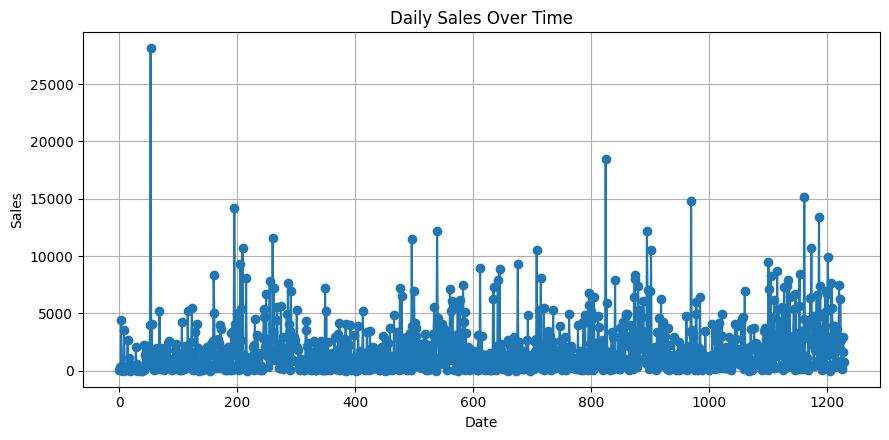

In [204]:
plt.figure(figsize=(9, 4.5))
plt.plot(all_daily.index, all_daily['Sales'], marker='o')
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

Monthly. This plot itself provides several information! As we could expect, the pattern shows some yearly seasonality and an increasing trend over the years.

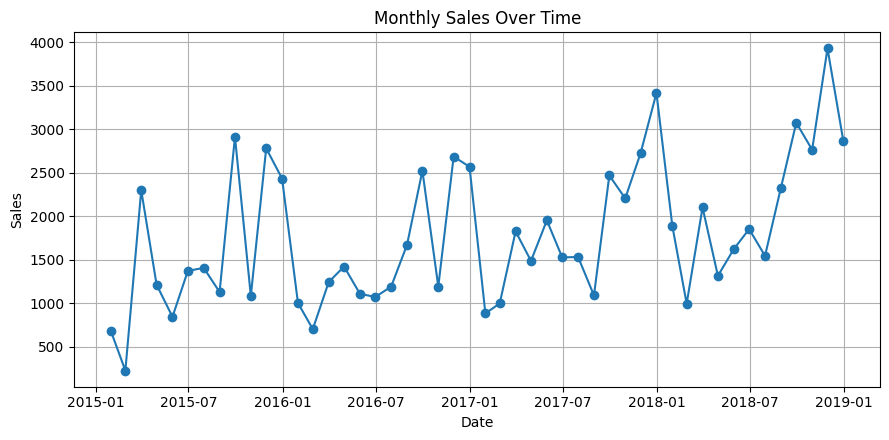

In [203]:
plt.figure(figsize=(9, 4.5))
plt.plot(all_monthly.index, all_monthly['Sales'], marker='o')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.grid(True)
plt.show()

Yearly. This plot shows us an evident increasing trend.

C:\Users\csier\AppData\Local\Temp\ipykernel_6480\2963636184.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  all_yearly = all_daily.set_index('Order Date').resample('Y').mean()


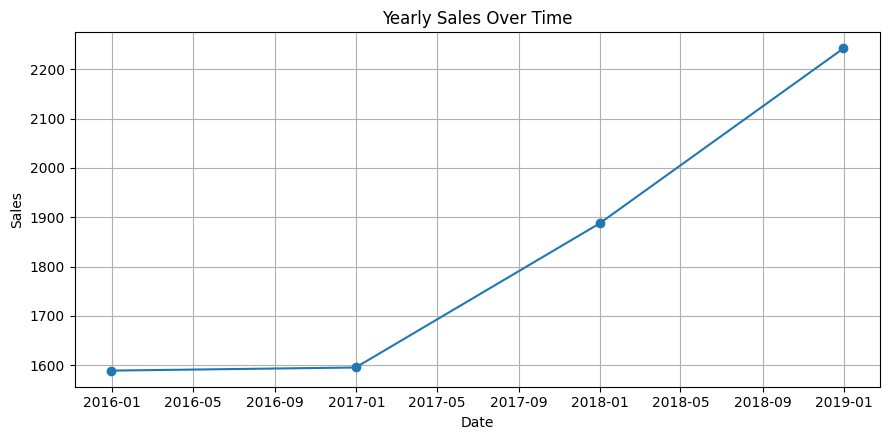

In [209]:
all_yearly = all_daily.set_index('Order Date').resample('Y').mean()

plt.figure(figsize=(9, 4.5))
plt.plot(all_yearly.index, all_yearly['Sales'], marker='o')
plt.title('Yearly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.grid(True)
plt.show()

To make it more interesting, we'll also take a look into the monthly sales by region!

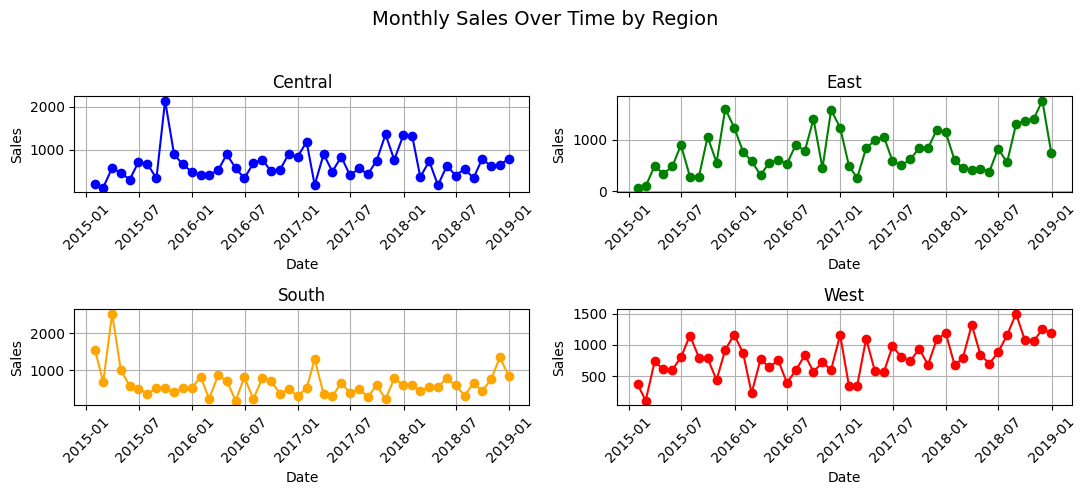

In [206]:
fig, axs = plt.subplots(2, 2, figsize=(11, 5))
fig.suptitle('Monthly Sales Over Time by Region', fontsize=14)

axs[0, 0].plot(central_monthly.index, central_monthly['Sales'], color='blue', marker='o')
axs[0, 0].set_title('Central')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Sales')
axs[0, 0].grid(True)

axs[0, 1].plot(east_monthly.index, east_monthly['Sales'], color='green', marker='o')
axs[0, 1].set_title('East')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Sales')
axs[0, 1].grid(True)

axs[1, 0].plot(south_monthly.index, south_monthly['Sales'], color='orange', marker='o')
axs[1, 0].set_title('South')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Sales')
axs[1, 0].grid(True)

axs[1, 1].plot(west_monthly.index, west_monthly['Sales'], color='red', marker='o')
axs[1, 1].set_title('West')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Sales')
axs[1, 1].grid(True)

for ax in axs.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

##### Seasonal Decomposition

As time series data can exhibit various of patterns, it's quite helpful to split a time series into components, each representing an underlying pattern category.

We'll use `seasonal_decompose` from statsmodel library, which allow us to split a time series in three components: **trend**, **seasonal** and **remainder** components.

Daily. For this case we have some missing values (228 out of 1230, about 18.5%) which we'll handle replacing by the integer mean value (1838) for simplicity.

In [224]:
missing_values = all_daily['Sales'].isnull().sum()
print(f'There are {missing_values} missing values in the dataset')

all_daily.describe()

There are 228 missing values in the dataset


,Sales
count,1230.000000
mean,1838.647791
std,2295.418267
min,2.025000
25%,378.519000
50%,1058.397000
75%,2382.217000
max,28106.716000


In [ ]:
all_daily['Sales'] = all_daily['Sales'].fillna(1838)

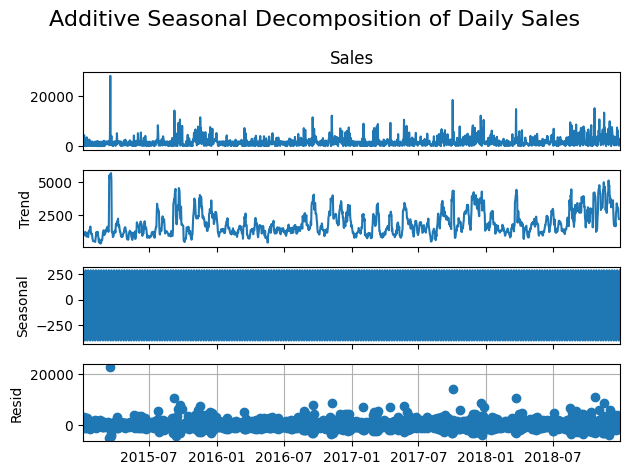

In [226]:
result = seasonal_decompose(all_daily['Sales'], model='additive')
result.plot()
plt.suptitle('Additive Seasonal Decomposition of Daily Sales', fontsize=16)
plt.tight_layout()
plt.grid(True)
plt.show()

Monthly.

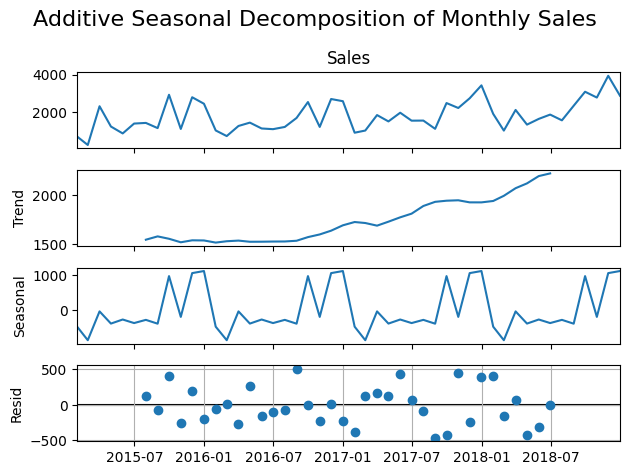

In [207]:
result = seasonal_decompose(all_monthly['Sales'], model='additive')
result.plot()
plt.suptitle('Additive Seasonal Decomposition of Monthly Sales', fontsize=16)
plt.tight_layout()
plt.grid(True)
plt.show()

Yearly.

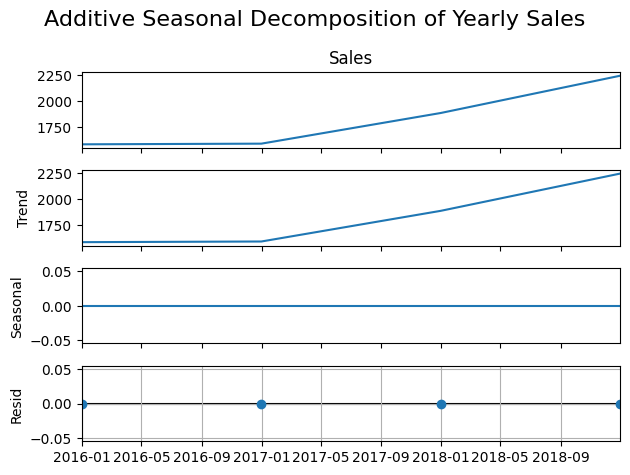

In [211]:
result = seasonal_decompose(all_yearly['Sales'], model='additive')
result.plot()
plt.suptitle('Additive Seasonal Decomposition of Yearly Sales', fontsize=16)
plt.tight_layout()
plt.grid(True)
plt.show()

#### Forecasting